# Определение возраста покупателей

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

В этом проекте нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Исследовательский анализ данных

Для начала загрузим данные.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Из полученного датафрейма вытащим картинки и приведем их в машиночитаемый вид.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Всего в датасете 7591 изображение. Посмотрим на их размерность. Для более удобной работы с данными разделим их на features и target,а затем посмотрим на размерность признаков.

In [6]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

Итак, в одном батче 32 картинки размером 224х224 и глубиной 3. Какие возраста присутствуют в целевом признке?

In [7]:
all_targets = []
for i in range(len(train_gen_flow)):
    all_targets += train_gen_flow[i][1].tolist()

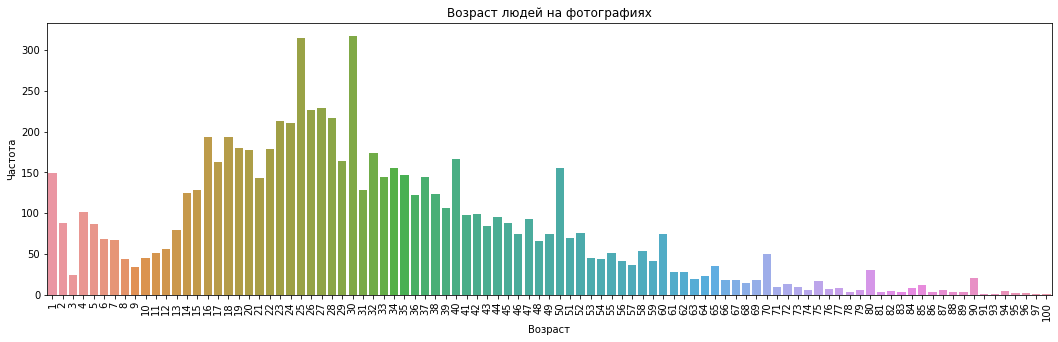

In [8]:
unique, counts = np.unique(all_targets, return_counts=True)
dict(zip(unique, counts))

fig, ax = plt.subplots(figsize=(18, 5))
sns.barplot(x=unique, y=counts)
plt.xticks(rotation=90)
ax.set_xlabel('Возраст')
ax.set_ylabel('Частота')
ax.set_title('Возраст людей на фотографиях');

Как видим, в датасете представлены возраста от 1 до 100 лет. Фотографий людей от 23 до примерно 40 лет больше всего. Такое распределение понятно — эти слои населения самые активные, их модель должна знать лучше всего. Плюс, в таком диапазоне возрастные особенности не слишком очевидны (люди могут примерно одинаково выглядеть и в 25 и в 35), соответственно, для обучения нужно больше данных. Не факт, что модель будет обучаться хуже на детях и пожилых людях из-за меньшего количества фото — признаки их возраста более просты в распознавании. Кроме того, в датасете присутствует немало фотографий людей 16-20 лет.
Взглянем на сами фотографии, а точнее на их часть.

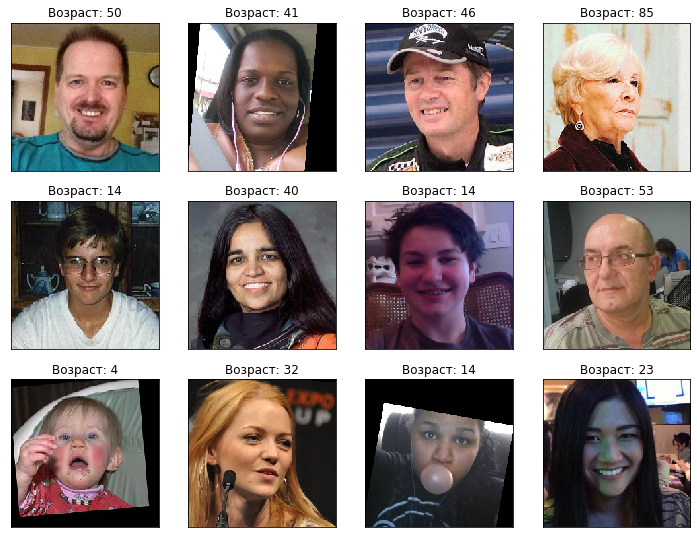

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Мы наблюдаем фото людей разных возрастов, рас, пола, некоторые лица представлены не в анфас. Всё это в теории должно помочь модели обучиться распознавать разные лица с разных ракурсов. Далее проведем обучение модели.

## Обучение модели

Ниже приведен код нейросети, использованной для распознавания возраста.

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


seed=0
import tensorflow as tf
tf.random.set_seed(seed)

import random
random.seed(seed)

np.random.seed(seed)


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                                        horizontal_flip=True)
    
    train_datagen_flow = datagen.flow_from_dataframe(
                                                dataframe=labels,
                                                directory=f'{path}final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                subset='training',
                                                batch_size=32,
                                                class_mode='raw',
                                                seed=seed)
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    val_datagen_flow = datagen.flow_from_dataframe(
                                                dataframe=labels,
                                                directory=f'{path}final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                subset='validation',
                                                batch_size=32,
                                                class_mode='raw',
                                                seed=seed)
    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
2021-05-03 17:49:24.309496: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-03 17:49:24.613358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 424.4266 - mae: 15.4256 - val_loss: 897.8453 - val_mae: 25.0751
Epoch 2/5
178/178 - 42s - loss: 86.1407 - mae: 6.9569 - val_loss: 960.0511 - val_mae: 26.1712
Epoch 3/5
178/178 - 42s - loss: 57.7354 - mae: 5.7623 - val_loss: 374.3472 - val_mae: 14.4158
Epoch 4/5
178/178 - 42s - loss: 41.2308 - mae: 4.8553 - val_loss: 134.7915 - val_mae: 9.1155
Epoch 5/5
178/178 - 42s - loss: 31.1196 - mae: 4.2644 - val_loss: 92.7246 - val_mae: 7.4813
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 92.7246 - mae: 7.4813
Test MAE: 7.4813


```

Итак, модель отработала с результатом MAE 7,4813 на валидационной выборке.

## Анализ обученной модели

Для распознавания возраста людей на фото мы использовали нейросеть ResNet50, предобученную на данных ImageNet. Эту сеть мы немного преобразовали, убрав верхушку и добавив один пулинг и один полносвязный слой. В качестве оптимизатора использовался алгоритм Adam со значением 0,0001. Такая ахитектура позволила нам добиться значения целевой метрики MAE ниже 8, а именно 7,4813, за 5 эпох.

Таким образом, полученная модель может определить возраст человека с точностью в чуть более 7 лет. Как уже говорилось ранее, сложность может вызывать определение возраста в диапазоне 25-40 лет. Наша модель может как минимум определить поколение, к которому такой человек принадлежит.